# Imports

In [1]:
import os

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
# Provided script to parse coco annotation data
import coco_text

# Constants

In [4]:
# Not sure how to properly handle ~ in Python, tell me if anyone know how
ANNOT_PATH = r'/home/rudi/Documents/Data/cocotext/COCO_Text.json'
IMAGES_DIR = r'/home/rudi/Documents/Data/cocotext/train2014_text_valid'
RANDOM_SEED = 4004

# Initialization

In [5]:
ct = coco_text.COCO_Text(ANNOT_PATH)

loading annotations into memory...
0:00:01.690501
creating index...
index created!


In [6]:
ct.info()

url: http://vision.cornell.edu/se3/coco-text/
date_created: 2017-03-28
version: 1.4
description: This is 1.4 version of the 2017 COCO-Text dataset.
author: COCO-Text group


In [7]:
# Get the list of annotation and image ids with certain filter
# Legible text, machine printed (screw handwriting)
train_image_ids = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible'),('class','machine printed')])
train_annotation_ids = ct.getAnnIds(imgIds=ct.train, 
                        catIds=[('legibility','legible'),('class','machine printed')])

In [8]:
# Build a dictionary of image IDs to their filepath
image_paths = {}
for image_name in os.listdir(IMAGES_DIR):
    image_id = int(image_name.split('.')[0].split('_')[-1])
    image_paths[image_id] = os.path.join(IMAGES_DIR,image_name)

# Data Parsing

In [9]:
# Sample annotation
anns = ct.loadAnns(train_annotation_ids[2500])
anns

[{'polygon': [192.31628799438477,
   250.37981605529785,
   271.8167381286621,
   250.37981605529785,
   271.8167381286621,
   284.60065269470215,
   192.31628799438477,
   284.60065269470215],
  'language': 'english',
  'area': 2720.5719168042124,
  'id': 1060494,
  'utf8_string': 'ASSOCIATION',
  'image_id': 423349,
  'bbox': [192.31628799438477,
   250.37981605529785,
   79.50045013427734,
   34.2208366394043],
  'legibility': 'legible',
  'class': 'machine printed'}]

In [10]:
# Sort images based on their total annotation area and count
from collections import defaultdict

# Minimum length of an annotation to be considered as valid
# So something like remote control won't be used as evaluation data
MIN_IMAGE_ANNOT_COUNT = 1
MIN_ANNOT_LENGTH = 5
MIN_ANNOT_AREA = 0

image_annot_count = defaultdict(int)
for annot_idx in range(len(train_annotation_ids)):
    annot = ct.loadAnns(train_annotation_ids[annot_idx])[0]
    image_annot_count[annot['image_id']] += 1 \
                                                if 'utf8_string' in annot.keys() and \
                                                    len(annot['utf8_string']) >= MIN_ANNOT_LENGTH and \
                                                    annot['area'] >= MIN_ANNOT_AREA \
                                            else 0
# Sort them by the count descending
image_annot_count = sorted(image_annot_count.items(), key=lambda x:x[1], reverse=True)

In [11]:
valid_images = [(image_id, annot_count) 
                         for image_id,annot_count in image_annot_count 
                         if annot_count >= MIN_IMAGE_ANNOT_COUNT]
valid_annots = [annot_count 
                         for image_id,annot_count in image_annot_count 
                         if annot_count >= MIN_IMAGE_ANNOT_COUNT]
print(f'Total valid images: {len(valid_images)}')
print(f'Total valid annotations: {sum(valid_annots)}')

Total valid images: 10084
Total valid annotations: 28882


# Visualisation

## Annot Count

In [12]:
def plot_annot_histogram(annots, bin_range, title=''):
    plt.figure(figsize=(9,6), facecolor='white')
    plt.title(title, fontsize=18)
    plt.gca().tick_params(axis = 'both', which = 'major', labelsize = 14)
    plt.xticks(bin_range)
    plt.xlabel('Number of annotations', fontsize=18)
    plt.ylabel('Number of data', fontsize=18)
    y,x,_ = plt.hist(annots, 
                 bins=bin_range, log=True,
                 edgecolor='black', linewidth=1.2)
    plt.ylim(0.6, max(y) * 10)
    for cur_x,cur_y in zip(x,y):
        if cur_y == 0:
            cur_y += 0.6
        # Don't mind this weird coordinate alloction, I'm just being anal with the centering
        plt.text(x = cur_x + (bin_range[1]-bin_range[0]) * 0.1 * (5 - len(str(int(cur_y)))), 
                 y = 1.1 * (cur_y),
                 s = int(cur_y), fontsize=12)

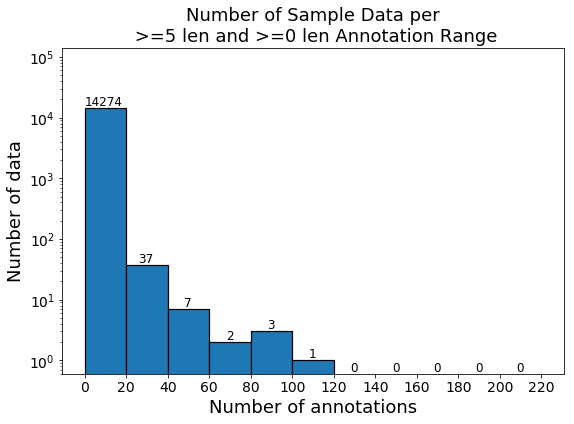

In [13]:
# Distribution of number of annotations on each image
num_annots = np.array([iac[1] for iac in image_annot_count])
bin_range = np.linspace(0,220,12)
plot_annot_histogram(num_annots, bin_range, 
                     'Number of Sample Data per\n >=' + str(MIN_ANNOT_LENGTH) + 
                     ' len and >=' + str(MIN_ANNOT_AREA) + ' len Annotation Range')

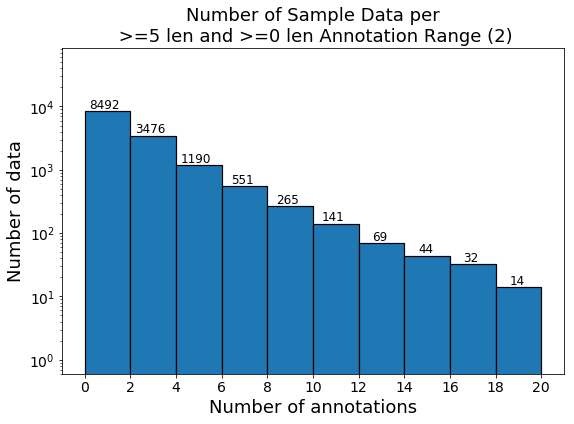

In [14]:
# Distribution of number of annotations on low annotation (0-19) images
bin_range = np.linspace(0,20,11)
plot_annot_histogram(num_annots[num_annots < 20], bin_range, 
                      'Number of Sample Data per\n >=' + str(MIN_ANNOT_LENGTH) + 
                     ' len and >=' + str(MIN_ANNOT_AREA) + ' len Annotation Range (2)')

In [15]:
# Sample from each bin range
BIN_RANGES = [(1,4),(4,10),(10,20),(20,40)]
NUM_SAMPLES = 4
bin_samples = {}
for br in BIN_RANGES:
    samples = [data[0] for data in image_annot_count if data[1] >= br[0] and data[1] < br[1]]
    np.random.seed(RANDOM_SEED)
    bin_samples[br] = np.random.choice(samples, NUM_SAMPLES, replace=False)

[580636 378189 190994]
[58597]


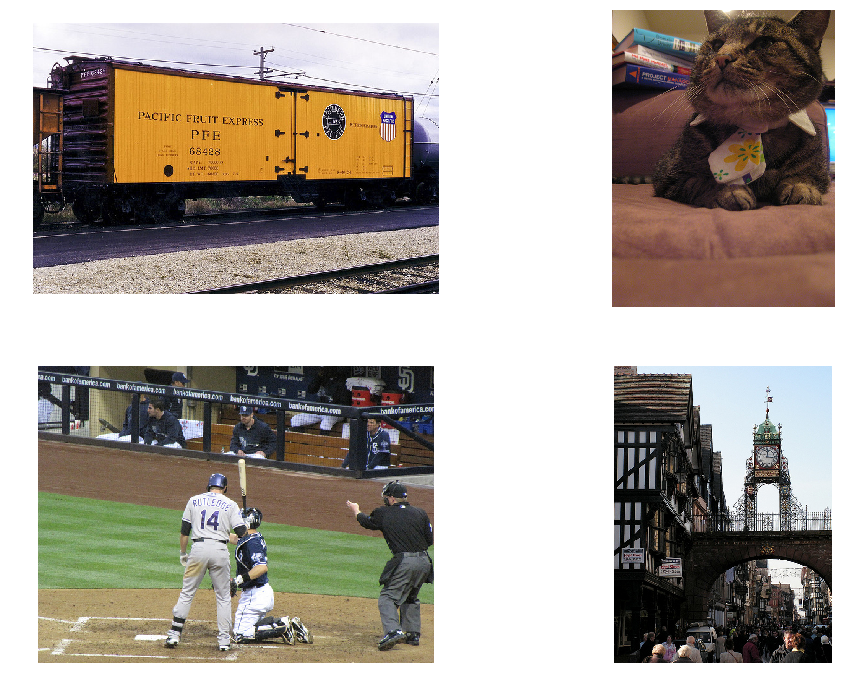

In [16]:
# And display them
BIN_RANGE = (4,10)
print(bin_samples[BIN_RANGE][:3])
print(bin_samples[BIN_RANGE][3:])
fig=plt.figure(figsize=(16, 12))
columns = int(NUM_SAMPLES / 2)
rows = 2
for i in range(1, columns*rows +1):
    image_index = bin_samples[BIN_RANGE][i - 1]
    img = mpimg.imread(image_paths[image_index])
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)
plt.show()

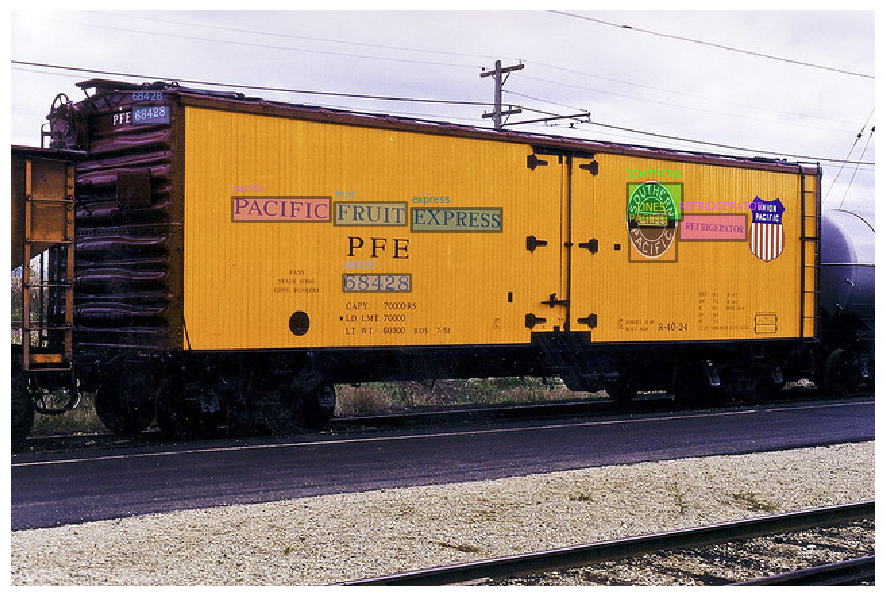

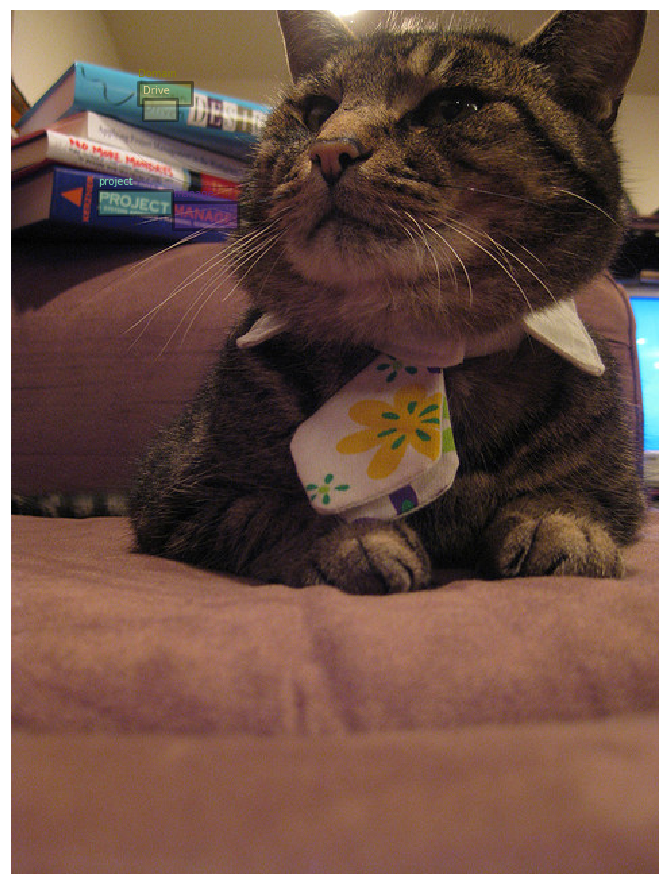

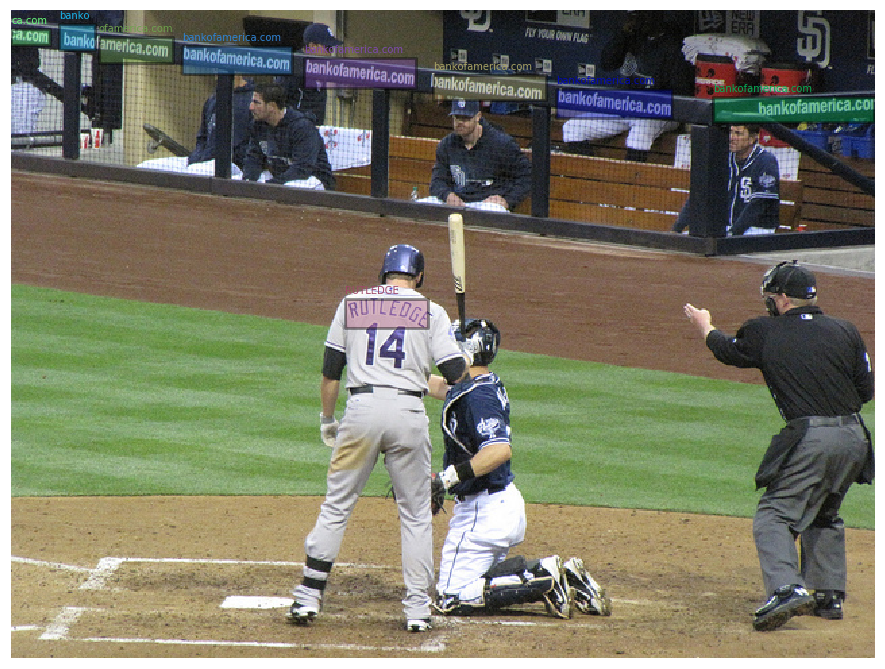

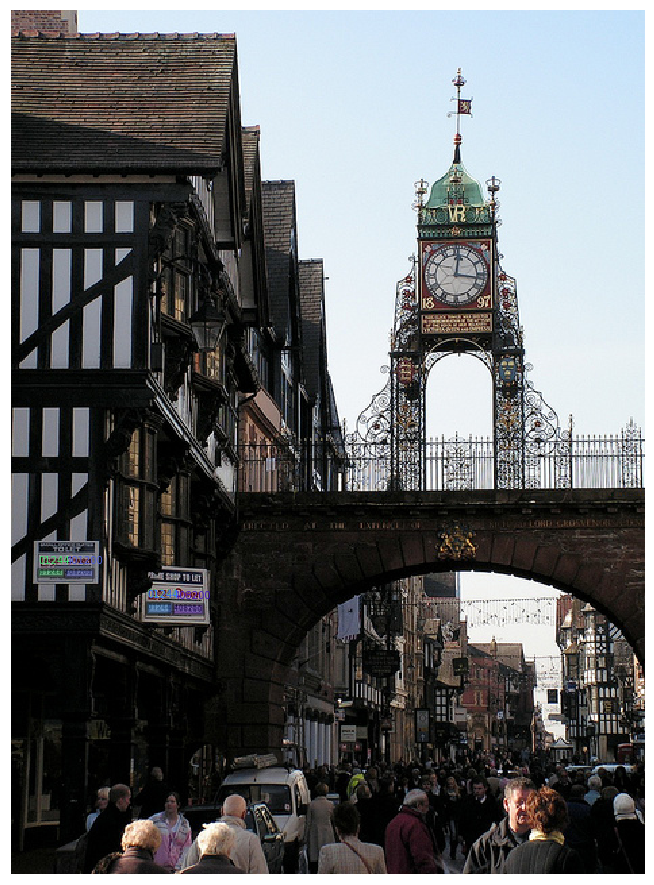

In [17]:
from matplotlib.ticker import NullLocator
# Display single image with all the annotations
# IMAGE_ID = 420372
IMAGE_IDS = bin_samples[BIN_RANGE]
#IMAGE_IDS = []

for image_id in IMAGE_IDS:
    img = mpimg.imread(image_paths[image_id])
    fig=plt.figure(figsize=(12,12),frameon=False)
    plt.axis('off')
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.imshow(img)
    annIds = ct.getAnnIds(imgIds=image_id)
    anns = ct.loadAnns(annIds)
    # Filter anns with the pre-determined area + len from before
    anns = [annot for annot in anns if 'utf8_string' in annot.keys() and \
                                                  len(annot['utf8_string']) >= MIN_ANNOT_LENGTH and \
                                                  annot['area'] >= MIN_ANNOT_AREA]
    ct.showAnns(anns)
    # Disable savefig
#     plt.savefig("visualisation/Image_Examples/" + 
#                 "{0:0=3d}".format(len(anns)) + 'anns_' +
#                 str(image_id) + '_' +
#                 str(MIN_ANNOT_LENGTH) + 'len_' + 
#                 str(MIN_ANNOT_AREA) + 'area.png', 
#                 bbox_inches='tight', pad_inches = 0)
    # Disable display
#     plt.close(fig)

In [18]:
print(len(image_annot_count))
print(len([data[0] for data in image_annot_count if data[1] >= 1 and data[1]]))

14324
10084


# Temporary

In [25]:
# Moving images with valid default text to a different directory
NEW_IMAGES_DIR = r'/home/rudi/Documents/Data/cocotext/train2014_text_valid'
for valid_image_id in train_image_ids:
    old_image_path = image_paths[valid_image_id]
    image_filename = ntpath.basename(old_image_path)
    new_image_path = os.path.join(NEW_IMAGES_DIR, image_filename)
    if os.path.isfile(old_image_path):
        shutil.move(old_image_path, new_image_path)

In [19]:
mini_det = ct.loadRes('/home/rudi/Documents/Data/cocotext/cocotext_ctpn_output.json')

Loading and preparing results...     
DONE (t=8.96s)


In [22]:
len(mini_det.getImgIds())

13533

In [23]:
mini_det.loadAnns(mini_det.getAnnIds()[1])

[{'image_id': 61526, 'bbox': [153, 112, 167, 37], 'area': 6179, 'id': 1}]

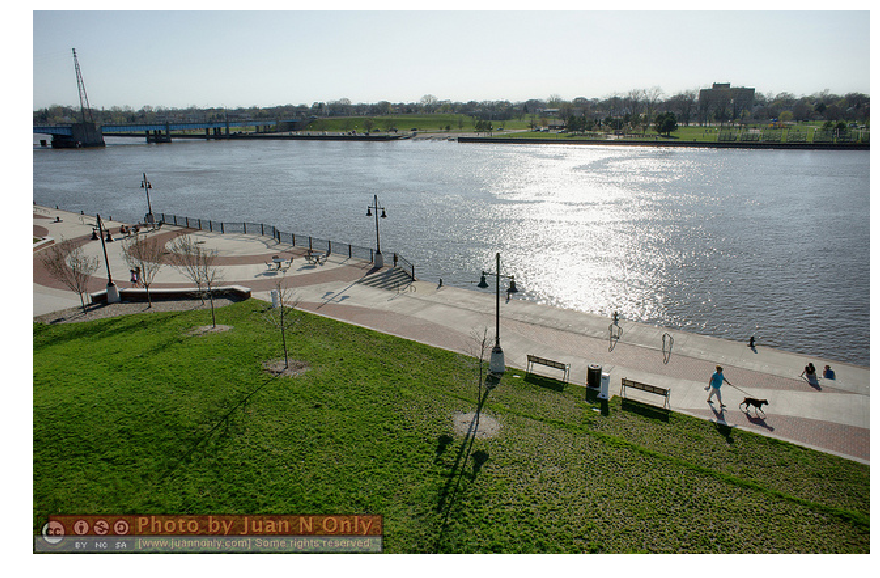

In [33]:
image = mpimg.imread(image_paths[109])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(image)
annIds = mini_det.getAnnIds(imgIds=109)
anns = mini_det.loadAnns(annIds)
ct.showAnns(anns)

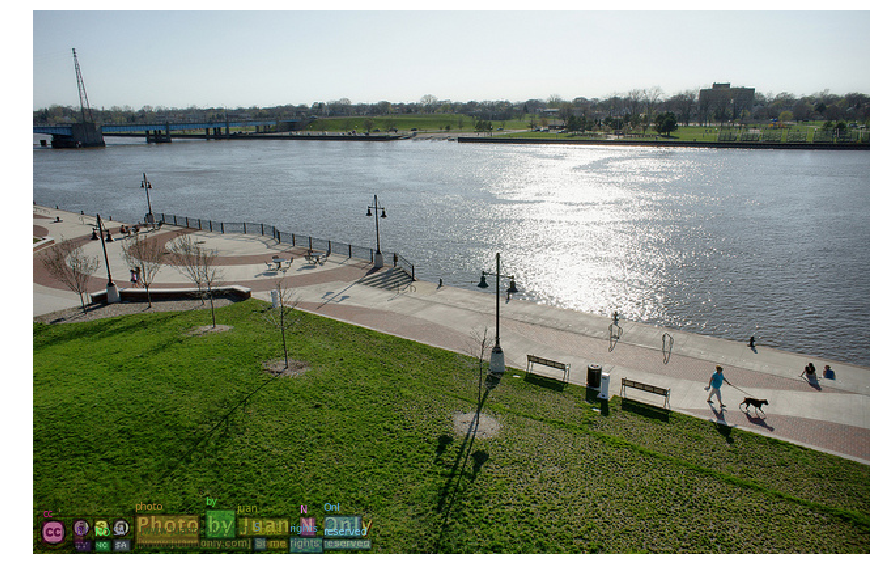

In [34]:
image = mpimg.imread(image_paths[109])
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(image)
annIds = ct.getAnnIds(imgIds=109)
anns = ct.loadAnns(annIds)
ct.showAnns(anns)